In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from os import listdir
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [3]:
indir = "/home/michael/Desktop/OpenData/SM_Backgrounds"
datadir = "/home/michael/Desktop/OpenData/data"
# The output file name tag to store the skim options used abvove
datatype = indir.split("/")[-1]
# In cases there is a trailing / at the end
if not datatype: datatype = indir.split("/")[-2]
print("INFO \t Data type is {:s}".format(datatype))
skimtag = "2L_pt25_25_met50"

# SM_Backgrounds_2L_pt25_25_met50_num_10.h5

rBackgroundEvents = 0.5
rSignalEvents = 0.5

INFO 	 Data type is SM_Backgrounds


In [4]:
bkgdir = "/home/michael/Desktop/OpenData/SM_Backgrounds"
sigdir = "/home/michael/Desktop/OpenData/data"
# The output file name tag to store the skim options used abvove
datatype = bkgdir.split("/")[-1]
# In cases there is a trailing / at the end
if not datatype: datatype = bkgir.split("/")[-2]
print("INFO \t Data type is {:s}".format(datatype))
skimtag = "2L_pt25_25_met50"

# SM_Backgrounds_2L_pt25_25_met50_num_10.h5

rBackgroundEvents = 0.5
rSignalEvents = 0.5

INFO 	 Data type is SM_Backgrounds


In [5]:
root_files = [f for f in listdir(indir) if (f.endswith('.h5') and f.startswith(datatype+"_"+skimtag))]
print("Will load the following {:d} files:\n{:s}".format(len(root_files),"\n".join(sorted(root_files))))

Will load the following 9 files:
SM_Backgrounds_2L_pt25_25_met50_num_1.h5
SM_Backgrounds_2L_pt25_25_met50_num_2.h5
SM_Backgrounds_2L_pt25_25_met50_num_3.h5
SM_Backgrounds_2L_pt25_25_met50_num_4.h5
SM_Backgrounds_2L_pt25_25_met50_num_5.h5
SM_Backgrounds_2L_pt25_25_met50_num_6.h5
SM_Backgrounds_2L_pt25_25_met50_num_7.h5
SM_Backgrounds_2L_pt25_25_met50_num_8.h5
SM_Backgrounds_2L_pt25_25_met50_num_9.h5


In [ ]:
nfile = 0
nx = 0
# Read all the root files with a given skim
for f in root_files:
    print("INFO  \t Opening file {:d}/{:d}: {:s}".format(nfile+1,len(root_files),f))
    df = pd.read_hdf(indir+"/"+f, 'mini')
    # Find the unique DSIDs in the file
    dsid = np.unique(df.iloc[:,[1]].as_matrix())
    # Loop over each DSID and put random selections into training and testing sample 
    for ids in dsid:
        print("Doing DSID {:d}. In this file: {:d} new DSIDs".format(nx+1,len(dsid)))
        newdf = df.loc[df['channelNumber'] == ids]
        # If X_test/train exists: concatenate, 
        # If not (i.e. we just wrote to a file): start new ones
        try:
            midl = newdf.sample(frac=rBackgroundEvents)
            X_train = pd.concat([X_train,midl],axis=0)
            X_test  = pd.concat([X_test, newdf.drop(midl.index.values)],axis=0)
            del [midl]
        except:
            X_train = newdf.sample(frac=rBackgroundEvents)
            X_test  = newdf.drop(X_train.index.values)
        del [newdf]
        nx += 1
        # Dump testing/training samples to file every now and then (here: every tenth DSID)
        if nx%10 == 0:
            path = indir+"/testing_bkg_%s_%i.h5"%(skimtag,nfile)
            print("Writing to file {:s}".format(path))
            X_test.to_hdf(path,key='result', mode='w')
            path = indir+"/training_bkg_%s_%i.h5"%(skimtag,nfile)
            print("Writing to file {:s}".format(path))
            X_train.to_hdf(path,key='result', mode='w')
            del [X_test]
            del [X_train]
    nfile += 1
    #if nfile > 2: break
    del [df]
    
# Needed in case we left without writing the last DSIDs to file
if nx%10 != 0:
    path = indir+"/testing_bkg_%s_%i.h5"%(skimtag,nfile)
    print("Writing to file {:s}".format(path))
    X_test.to_hdf(path,key='result', mode='w')
    path = indir+"/training_bkg_%s_%i.h5"%(skimtag,nfile)
    print("Writing to file {:s}".format(path))
    X_train.to_hdf(path,key='result', mode='w')
    del [X_test]
    del [X_train]

# Plotting
The following cells show an example on how to plot the variables stored in the data frame.

BFrist we retrieve the name of all the training and testing files just created

In [6]:
testing_files = [f for f in listdir(indir) if (f.endswith('.h5') and f.startswith("testing_bkg_"+skimtag))]
print("TESTING:  Will load the following {:d} files:\n{:s}".format(len(testing_files),"\n".join(sorted(testing_files))))
training_files = [f for f in listdir(indir) if (f.endswith('.h5') and f.startswith("training_bkg_"+skimtag))]
print("TRAINING: Will load the following {:d} files:\n{:s}".format(len(training_files),"\n".join(sorted(training_files))))

TESTING:  Will load the following 8 files:
testing_bkg_2L_pt25_25_met50_0.h5
testing_bkg_2L_pt25_25_met50_1.h5
testing_bkg_2L_pt25_25_met50_2.h5
testing_bkg_2L_pt25_25_met50_3.h5
testing_bkg_2L_pt25_25_met50_5.h5
testing_bkg_2L_pt25_25_met50_7.h5
testing_bkg_2L_pt25_25_met50_8.h5
testing_bkg_2L_pt25_25_met50_9.h5
TRAINING: Will load the following 8 files:
training_bkg_2L_pt25_25_met50_0.h5
training_bkg_2L_pt25_25_met50_1.h5
training_bkg_2L_pt25_25_met50_2.h5
training_bkg_2L_pt25_25_met50_3.h5
training_bkg_2L_pt25_25_met50_5.h5
training_bkg_2L_pt25_25_met50_7.h5
training_bkg_2L_pt25_25_met50_8.h5
training_bkg_2L_pt25_25_met50_9.h5


Then we load the files. If we want to load the whole set (test+trainin) or only one of them can be specified in *load_files*

In [7]:
nfile = 0
load_files = testing_files+training_files
for f in load_files:
    print("INFO  \t Opening file {:d}/{:d}: {:s}".format(nfile+1,len(load_files),f))
    df = pd.read_hdf(indir+"/"+f, 'result')
    try:
        X_train = pd.concat([X_train,df],axis=0)
    except:
        X_train = df
    del [df]
    nfile += 1
    #break

INFO  	 Opening file 1/16: testing_bkg_2L_pt25_25_met50_9.h5
INFO  	 Opening file 2/16: testing_bkg_2L_pt25_25_met50_7.h5
INFO  	 Opening file 3/16: testing_bkg_2L_pt25_25_met50_2.h5
INFO  	 Opening file 4/16: testing_bkg_2L_pt25_25_met50_1.h5
INFO  	 Opening file 5/16: testing_bkg_2L_pt25_25_met50_5.h5
INFO  	 Opening file 6/16: testing_bkg_2L_pt25_25_met50_0.h5
INFO  	 Opening file 7/16: testing_bkg_2L_pt25_25_met50_3.h5
INFO  	 Opening file 8/16: testing_bkg_2L_pt25_25_met50_8.h5
INFO  	 Opening file 9/16: training_bkg_2L_pt25_25_met50_8.h5
INFO  	 Opening file 10/16: training_bkg_2L_pt25_25_met50_0.h5
INFO  	 Opening file 11/16: training_bkg_2L_pt25_25_met50_5.h5
INFO  	 Opening file 12/16: training_bkg_2L_pt25_25_met50_1.h5
INFO  	 Opening file 13/16: training_bkg_2L_pt25_25_met50_2.h5
INFO  	 Opening file 14/16: training_bkg_2L_pt25_25_met50_9.h5
INFO  	 Opening file 15/16: training_bkg_2L_pt25_25_met50_7.h5
INFO  	 Opening file 16/16: training_bkg_2L_pt25_25_met50_3.h5


In [8]:
# Add data
data_files = [f for f in listdir(datadir) if (f.endswith('.h5') and f.startswith("data_"+skimtag))]
print("Will load the following {:d} file(s) for data:\n{:s}".format(len(data_files),"\n".join(sorted(data_files))))

Will load the following 1 file(s) for data:
data_2L_pt25_25_met50_num_1.h5


In [9]:
# Concatenate the data (not strictly needed if only 1 file)
nfile = 0
for f in data_files:
    print("INFO  \t Opening file {:d}/{:d}: {:s}".format(nfile+1,len(data_files),f))
    df = pd.read_hdf(datadir+"/"+f, 'mini')
    try:
        X_data = pd.concat([X_data,df],axis=0)
    except:
        X_data = df
    del [df]  
    nfile += 1

INFO  	 Opening file 1/1: data_2L_pt25_25_met50_num_1.h5


Some plotting specific setting (order of plotting, color of backgrounds).The *stack_order* must have the same keys as in the *MCType* column in the data frame

In [10]:
stack_order = ['Data','Wjets','Top','Diboson','Zjets']
samples = {'Wjets':{'color':"#e55934"},
           'Zjets':{'color':"#086788"},
           'Top':{'color':"#9bc53d"},
           'Diboson':{'color':"#fa7921"}}
bkgs = X_train['MCType'].unique()
for s in stack_order:
    if "Data" in s: continue
    if not s in bkgs: print("ERROR \t Key {:s} is not in panda".format(s))

Extract the numpy arrays from the panda data frame (specify the variable of interest in *var*). Here the limits, bin width etc. are set. 

In [11]:
mc_mll = []
mc_weights = []
mc_colors = []
mc_labels = []

data_mll = []
data_mll_errors = []

var = "lep1_pt"
top = -999

nmax = 1000
nmin = 0
binw = 20

data_x = []
if not ((nmax-nmin)/binw).is_integer():
    print("ERROR \t Limits and bin width are not compatible")
print(int((nmax-nmin)/binw)+1)
bins = [nmin + (x*binw) for x in range(int((nmax-nmin)/binw)+1)]
for i in range(len(bins)-1):
    print(bins[i])
    data_x.append(bins[i]+(bins[i+1]-bins[i])/2)
#data_x = [((nmin+1) + x*binw) for x in range(int((nmax-nmin)/binw)) ]

for s in stack_order:
    if s == "Data":
        data_mll,_ = np.histogram(X_data.as_matrix(columns=X_data.columns[X_data.columns.get_loc(var):X_data.columns.get_loc(var)+1])/1000., bins=bins)
        data_mll_errors = np.sqrt(data_mll)
    else:
        rslt_df = X_train.loc[X_train['MCType'] == s]
        mc_mll.append(rslt_df.as_matrix(columns=rslt_df.columns[rslt_df.columns.get_loc(var):rslt_df.columns.get_loc(var)+1])/1000.)
        mc_weights.append(rslt_df.as_matrix(columns=rslt_df.columns[rslt_df.columns.get_loc("wgt"):rslt_df.columns.get_loc("wgt")+1])*(1000.))
        mc_colors.append(samples[s]['color'])
        mc_labels.append(s)
        if np.amax(mc_mll[-1]) > top:
            top = np.amax(mc_mll[-1])
        del [rslt_df]
    print(s)
        

51
0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
Data


/home/michael/anaconda2/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:28: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/michael/anaconda2/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:32: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/michael/anaconda2/envs/root_env/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Wjets
Top
Diboson
Zjets


Finally, do the plotting:

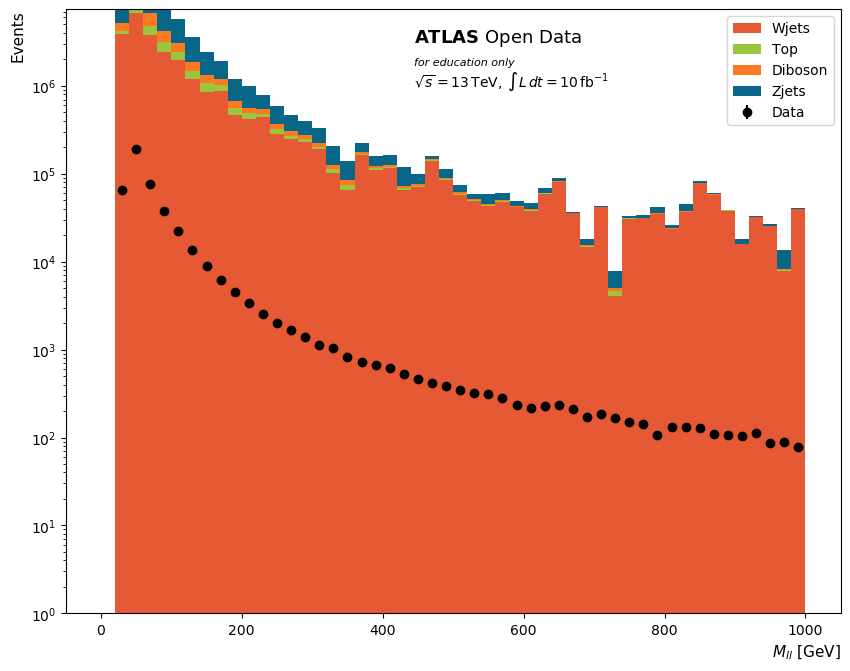

In [12]:
figure(num=None, figsize=(10, 8), dpi=100, facecolor='w', edgecolor='k')
plt.hist(mc_mll,bins=bins,weights=mc_weights,stacked=True,color=mc_colors, label=mc_labels); #weights=mc_weights,
plt.errorbar( x=data_x, y=data_mll, yerr=data_mll_errors, fmt='ko', label='Data')
plt.yscale('log')
plt.ylabel(r'Events',fontname='sans-serif',horizontalalignment='right',y=1.0,fontsize=11)
plt.xlabel(r'$M_{ll}$ [GeV]',fontname='sans-serif',horizontalalignment='right',x=1.0,fontsize=11)

plt.ylim(bottom=1,top=top*10)

ax = plt.gca()
plt.text(0.45,0.97,r'$\mathbf{{ATLAS}}$ Open Data',ha="left",va="top",family='sans-serif',transform=ax.transAxes,fontsize=13)
plt.text(0.45,0.92,'for education only',ha="left",va="top",family='sans-serif',transform=ax.transAxes,style='italic',fontsize=8)
plt.text(0.45,0.90,r'$\sqrt{s}=13\,\mathrm{TeV},\;\int L\,dt=10\,\mathrm{fb}^{-1}$',ha="left",va="top",family='sans-serif',transform=ax.transAxes)


plt.legend()


In [ ]:
mc_mll[0].shape

In [ ]:
data_x